In [1]:
import requests
import pandas as pd
import time
import random
import xml.etree.ElementTree as ET
from datetime import datetime
import matplotlib.pyplot as plt

RSS_FEEDS = {
    "Antara": "https://www.antaranews.com/rss/lifestyle.xml",
    "Liputan6": "https://feed.liputan6.com/rss/lifestyle",
}

HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}

In [2]:
def scrape_rss(source_name, url, max_articles=20):
    print(f"\n🔍 Scraping {source_name} RSS (kategori: Lifestyle)...")
    articles = []

    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        if response.status_code != 200:
            print(f"⚠️ Gagal akses {source_name}: {response.status_code}")
            return articles

        root = ET.fromstring(response.content)
        items = root.findall(".//item")

        for item in items[:max_articles]:
            title = item.find("title").text if item.find("title") is not None else None
            link = item.find("link").text if item.find("link") is not None else None
            pub_date = item.find("pubDate").text if item.find("pubDate") is not None else None
            description = item.find("description").text if item.find("description") is not None else None

            # 🔹 Kategorinya langsung set ke "Lifestyle"
            categories = ["Lifestyle"]

            # 🔹 Format tanggal ISO 8601
            try:
                pub_date = datetime.strptime(pub_date[:25], "%a, %d %b %Y %H:%M:%S").isoformat()
            except:
                pub_date = None

            articles.append({
                "title": title,
                "url": link,
                "categories": categories,
                "summary": description,
                "source": source_name,
                "published_at": pub_date,
                "scraped_at": datetime.now().isoformat()
            })

            time.sleep(random.uniform(0.5, 1.2))  # jeda antar artikel

        time.sleep(random.uniform(1, 2))  # jeda antar sumber
        print(f"✅ Berhasil ambil {len(articles)} artikel dari {source_name} (kategori: Lifestyle)")
        return articles

    except Exception as e:
        print(f"⚠️ Error saat scrape {source_name}: {e}")
        return articles

In [3]:
all_articles = []
for source, url in RSS_FEEDS.items():
    data = scrape_rss(source, url, max_articles=30)
    all_articles.extend(data)

print(f"\nTotal artikel sebelum pembersihan: {len(all_articles)}")


🔍 Scraping Antara RSS (kategori: Lifestyle)...
✅ Berhasil ambil 20 artikel dari Antara (kategori: Lifestyle)

🔍 Scraping Liputan6 RSS (kategori: Lifestyle)...
✅ Berhasil ambil 30 artikel dari Liputan6 (kategori: Lifestyle)

Total artikel sebelum pembersihan: 50


In [4]:
df = pd.DataFrame(all_articles)
df.drop_duplicates(subset=["title"], inplace=True)
df.dropna(subset=["title"], inplace=True)
df = df.head(50)

In [5]:
df.to_csv("news_dataset.csv", index=False, encoding="utf-8-sig")
print(f"\n📁 Dataset disimpan sebagai 'news_dataset.csv' ({len(df)} artikel)")


📁 Dataset disimpan sebagai 'news_dataset.csv' (50 artikel)


In [6]:
print("\n📊 ANALISIS DESKRIPTIF DATASET")

# Pastikan kolom tanggal valid (ada atau tidak)
if 'published_at' in df.columns:
    df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')
    tanggal_valid = df['published_at'].dropna()
    if not tanggal_valid.empty:
        rentang_tanggal = f"{tanggal_valid.min().date()} — {tanggal_valid.max().date()}"
    else:
        rentang_tanggal = "Tanggal publikasi tidak tersedia"
else:
    rentang_tanggal = "Kolom tanggal tidak ditemukan"

# --- Jumlah artikel per sumber ---
artikel_per_sumber = df['source'].value_counts()

# Misalnya, kita ambil kata-kata populer dari kolom summary
from collections import Counter
import re

def ambil_kata_populer(text_series, top_n=5):
    all_words = []
    for text in text_series.dropna():
        words = re.findall(r'\b[a-zA-Z]{4,}\b', text.lower())
        all_words.extend(words)
    return Counter(all_words).most_common(top_n)

kata_populer = ambil_kata_populer(df['summary'], top_n=5)

# --- Tampilkan hasil deskriptif ---
print("\n📌 Jumlah Artikel per Sumber:")
print(artikel_per_sumber)
print(f"\n🗓️ Rentang Tanggal Publikasi: {rentang_tanggal}")

print("\n🔥 Kata Kunci Populer (dari kolom summary):")
for kata, jumlah in kata_populer:
    print(f"- {kata} ({jumlah}x)")



📊 ANALISIS DESKRIPTIF DATASET

📌 Jumlah Artikel per Sumber:
source
Liputan6    30
Antara      20
Name: count, dtype: int64

🗓️ Rentang Tanggal Publikasi: 2025-10-24 — 2025-10-29

🔥 Kata Kunci Populer (dari kolom summary):
- yang (31x)
- https (20x)
- antaranews (20x)
- cache (20x)
- align (20x)


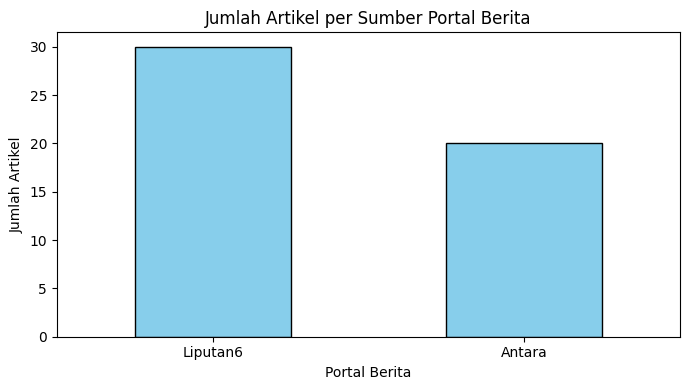

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
artikel_per_sumber.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Jumlah Artikel per Sumber Portal Berita")
plt.xlabel("Portal Berita")
plt.ylabel("Jumlah Artikel")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()